In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
# Download training dataset
MNIST_Data = MNIST(root='data/', download=True)

In [3]:
len(MNIST_Data)

60000

In [4]:
test = MNIST(root='data/', train=False)
len(test)

10000

In [5]:
MNIST_Data = MNIST(root='data/', download=True, transform=ToTensor())

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image.shape: torch.Size([1, 28, 28])
Label: 2


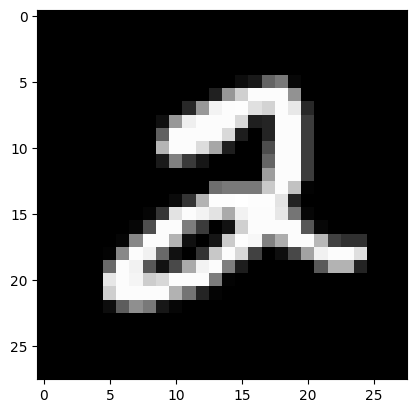

In [7]:
image, label = MNIST_Data[5]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 3


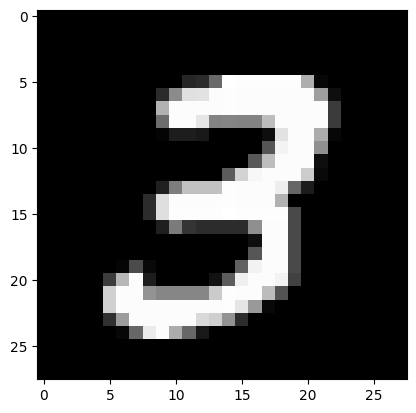

In [8]:
image, label = MNIST_Data[7]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 3


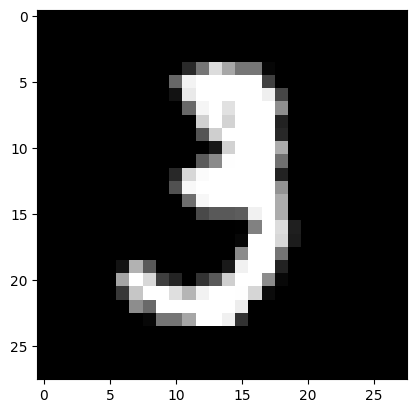

In [9]:
image, label = MNIST_Data[10]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [10]:
from torch.utils.data import random_split

In [11]:
validation_size = 10000
train_size = len(MNIST_Data) - validation_size
train, validation = random_split(MNIST_Data, [train_size, validation_size])
len(train), len(validation)

(50000, 10000)

In [12]:
batch_size=200

In [13]:
from torch.utils.data.dataloader import DataLoader

In [14]:
train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(validation, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
from torchvision.utils import make_grid

images.shape: torch.Size([200, 1, 28, 28])


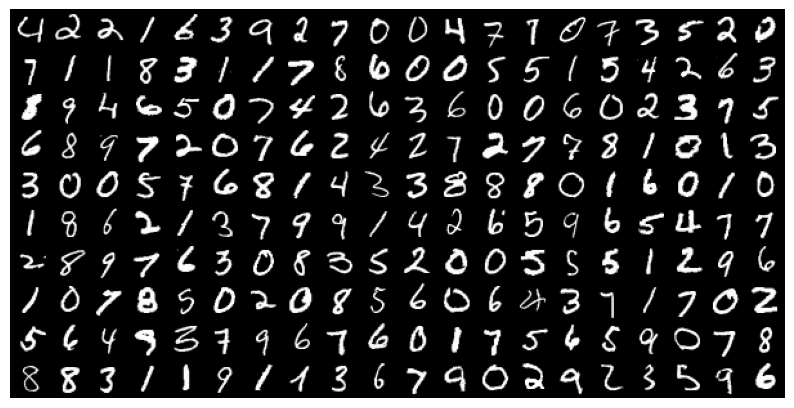

In [16]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(10,20))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=20).permute((1, 2, 0)))
    break

In [17]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([200, 1, 28, 28])
inputs.shape: torch.Size([200, 784])


In [18]:
input_size = inputs.shape[-1]
print(input_size)

784


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoHiddenLayerModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(TwoHiddenLayerModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size2, output_size)


    def forward(self, xb):
    # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
    # Get intermediate outputs using hidden layer
        out = self.layer1(xb)
    # Apply activation function
        out = self.activation1(out)
    # Get predictions using output layer
        out = self.layer2(out)
    # Apply activation function
        out = self.activation2(out)
    # Get final predictions using output layer
        out = self.output_layer(out)
        return out


    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))




In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
input_size = 784
hidden_size1 = 64
hidden_size2= 32
num_classes = 10

In [22]:
model = TwoHiddenLayerModel(input_size, hidden_size1, hidden_size2, output_size=num_classes)

In [23]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [24]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.307924747467041
outputs.shape :  torch.Size([200, 10])
Sample outputs :
 tensor([[ 0.1674,  0.1676,  0.0170,  0.0900,  0.1310, -0.0932,  0.1585,  0.1698,
          0.0612, -0.0703],
        [ 0.1634,  0.1570,  0.0481,  0.0651,  0.1574, -0.0845,  0.1479,  0.1453,
          0.0429, -0.0353]])


In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [28]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([200, 1, 28, 28])
cuda:0


In [29]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [31]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 2, 8, 1, 1, 2, 1, 9, 7, 1, 1, 2, 9, 0, 6, 0, 1, 3, 8, 8, 4, 1, 7, 2,
        8, 6, 4, 2, 3, 6, 6, 4, 6, 4, 6, 7, 0, 1, 7, 4, 4, 2, 6, 5, 0, 9, 1, 4,
        2, 5, 7, 7, 4, 7, 9, 4, 0, 6, 5, 1, 3, 0, 4, 9, 7, 5, 4, 9, 0, 4, 8, 9,
        8, 1, 9, 8, 5, 1, 8, 4, 2, 7, 8, 4, 5, 5, 9, 2, 3, 8, 2, 3, 9, 9, 1, 1,
        9, 9, 4, 5, 8, 4, 9, 9, 5, 6, 6, 8, 3, 9, 3, 8, 8, 9, 7, 9, 6, 7, 5, 0,
        7, 2, 8, 6, 7, 8, 7, 3, 7, 8, 9, 1, 0, 3, 1, 9, 5, 5, 5, 1, 7, 7, 5, 2,
        0, 4, 5, 8, 7, 7, 4, 0, 4, 8, 0, 7, 1, 9, 1, 6, 1, 9, 9, 8, 9, 4, 4, 0,
        3, 1, 9, 1, 6, 3, 1, 1, 3, 1, 5, 0, 6, 4, 2, 7, 5, 6, 8, 8, 5, 2, 9, 1,
        3, 7, 7, 0, 8, 5, 4, 0, 3, 3, 1, 0, 2, 5, 9, 9, 1, 4, 3, 9, 5, 0, 4, 7,
        2, 0, 5, 4, 8, 5, 1, 5, 6, 3, 0, 3, 7, 6, 3, 7, 7, 6, 0, 1, 4, 6, 9, 3,
        4, 9, 4, 8, 1, 4, 6, 3, 3, 7, 1, 3, 5, 1, 9, 3, 6, 5, 5, 9, 1, 9, 2, 9,
        6, 1, 4, 5, 4, 0, 1, 3, 2, 9, 0, 3, 1, 3, 2, 2, 0, 6, 0, 5, 1, 1, 9, 3,
        0, 8, 6, 0

In [32]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
# Model (on GPU)
model = TwoHiddenLayerModel(input_size, hidden_size1, hidden_size2, output_size=num_classes)
to_device(model, device)

TwoHiddenLayerModel(
  (layer1): Linear(in_features=784, out_features=64, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (activation2): ReLU()
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.307607412338257, 'val_acc': 0.09000000357627869}]

In [35]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2190, val_acc: 0.9361
Epoch [1], val_loss: 0.1568, val_acc: 0.9535
Epoch [2], val_loss: 0.1258, val_acc: 0.9637
Epoch [3], val_loss: 0.1225, val_acc: 0.9644
Epoch [4], val_loss: 0.1128, val_acc: 0.9672
Epoch [5], val_loss: 0.1075, val_acc: 0.9683
Epoch [6], val_loss: 0.1063, val_acc: 0.9672
Epoch [7], val_loss: 0.1282, val_acc: 0.9646
Epoch [8], val_loss: 0.1102, val_acc: 0.9682
Epoch [9], val_loss: 0.1080, val_acc: 0.9712


In [36]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0949, val_acc: 0.9738
Epoch [1], val_loss: 0.0942, val_acc: 0.9747
Epoch [2], val_loss: 0.0937, val_acc: 0.9740
Epoch [3], val_loss: 0.0940, val_acc: 0.9739
Epoch [4], val_loss: 0.0941, val_acc: 0.9743


In [37]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0937, val_acc: 0.9744
Epoch [1], val_loss: 0.0938, val_acc: 0.9742
Epoch [2], val_loss: 0.0938, val_acc: 0.9745
Epoch [3], val_loss: 0.0939, val_acc: 0.9743
Epoch [4], val_loss: 0.0940, val_acc: 0.9743


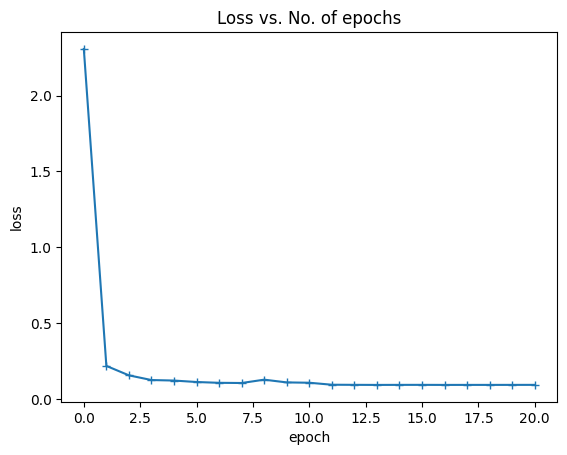

In [38]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-+')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

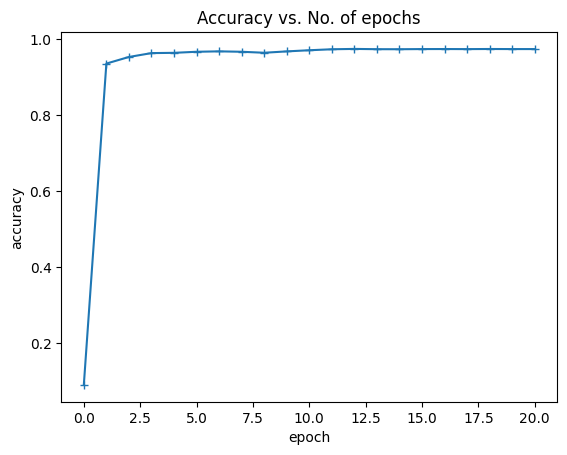

In [39]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-+')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [40]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [41]:
test = MNIST(root='data/', train=False, transform=ToTensor())

Label: 1 , Predicted: 1


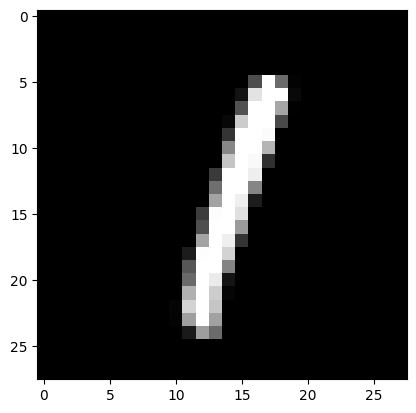

In [42]:
img, label = test[5]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


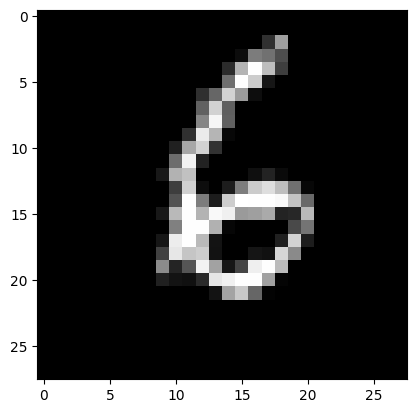

In [43]:
img, label = test[2000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [44]:
test_loader = DeviceDataLoader(DataLoader(test, batch_size=400), device)
result = evaluate(model, test_loader)
final_result = {'test_loss': result['val_loss'], 'test_acc': result['val_acc']}
print(final_result)

{'test_loss': 0.07843168079853058, 'test_acc': 0.9778000712394714}


In [45]:
file_path = '/content/Deep Learning/MNIST.pth'

# Save the model
torch.save(model.state_dict(), file_path)